Mounted at /content/drive
Dataset folders: ['val', 'train', 'test', 'label_colors.txt']
Train: 811 images
Val: 203 images
Test: 254 images


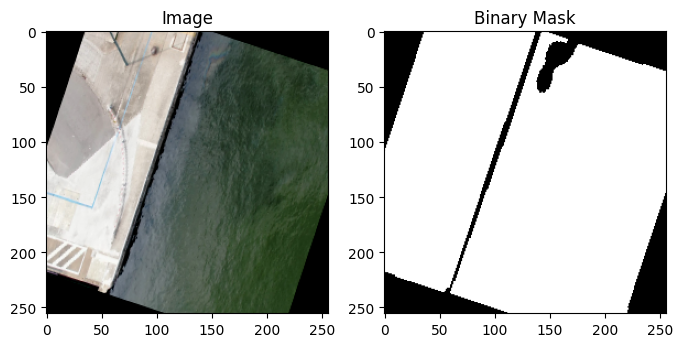

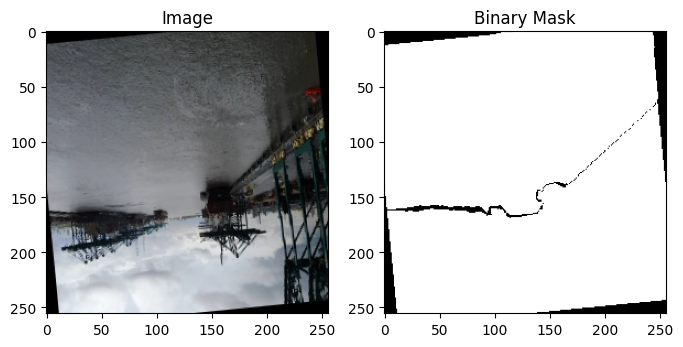

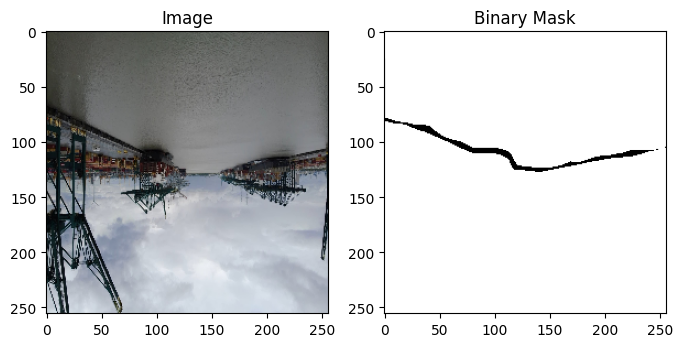

 Dataset loaded, preprocessed & augmented successfully.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset, DataLoader

# mount google drive (only once for dataset loading)
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = "/content/drive/MyDrive/infosys/oil_spill_dataset"

print("Dataset folders:", os.listdir(DATASET_PATH))


# utility functions: preprocessing of raw data
def load_image(path):
    """Load image in RGB"""
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def load_mask(path):
    """Load mask and convert RGB -> binary (spill vs non-spill)"""
    mask = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) # convert to grayscale
    _, binary = cv2.threshold(gray, 127, 1, cv2.THRESH_BINARY)     # binary threshold (0 = non-spill(backgrouund), 1 = spill)
    return binary


# custom dataset class
class OilSpillDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = load_image(self.images[idx])
        mask = load_mask(self.masks[idx])

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image, mask = aug['image'], aug['mask']

        return image, mask.long()
# augmentation+ preprocessing



# data paths
train_images = sorted(glob(os.path.join(DATASET_PATH, "train/images/*")))
train_masks  = sorted(glob(os.path.join(DATASET_PATH, "train/masks/*")))
val_images   = sorted(glob(os.path.join(DATASET_PATH, "val/images/*")))
val_masks    = sorted(glob(os.path.join(DATASET_PATH, "val/masks/*")))
test_images  = sorted(glob(os.path.join(DATASET_PATH, "test/images/*")))
test_masks   = sorted(glob(os.path.join(DATASET_PATH, "test/masks/*")))

print(f"Train: {len(train_images)} images")
print(f"Val: {len(val_images)} images")
print(f"Test: {len(test_images)} images")


# transformations +augmentation
# basic preprocessing (resize + normalize)
basic_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

# augmentation (to balance classes if imbalanced)
augment_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])


# datasets & loaders
train_dataset = OilSpillDataset(train_images, train_masks, transform=augment_transform)
val_dataset   = OilSpillDataset(val_images, val_masks, transform=basic_transform)

train_loader  = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=8, shuffle=False)
# this was whole data input pipeline for model training



# visualization pipeline
def denormalize(image):
    """Convert from [-1,1] back to [0,1] for display"""
    image = (image * 0.5) + 0.5
    return np.clip(image, 0, 1)

def visualize_sample(dataset, n=3):
    for i in range(n):
        image, mask = dataset[i]
        image = image.permute(1,2,0).numpy()  # CHW -> HWC
        image = denormalize(image)             # fix warnings
        mask = mask.numpy()

        fig, ax = plt.subplots(1, 2, figsize=(8,4))
        ax[0].imshow(image)
        ax[0].set_title("Image")
        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title("Binary Mask")
        plt.show()

visualize_sample(train_dataset, n=3)

print(" Dataset loaded, preprocessed & augmented successfully.")


Data Input & Preprocessing Pipeline:

- Mounted Google Drive and set dataset path.

- Defined utility functions to load images and masks (converted RGB masks into binary segmentation masks).

- Built a custom PyTorch Dataset class OilSpillDataset to handle paired image-mask loading with optional augmentations.

- Created separate train, validation, and test sets by loading paths and applying Albumentations transformations:

Basic Transform → Resize + Normalize

Augment Transform → Resize, Flips, Rotations, Brightness/Contrast, Normalize

- Initialized PyTorch DataLoaders for batching and shuffling.

- Added visualization utilities (visualize_sample) to check if preprocessing and augmentations are applied correctly.
- At this stage, we ensured dataset is structured, normalized, and ready for training.

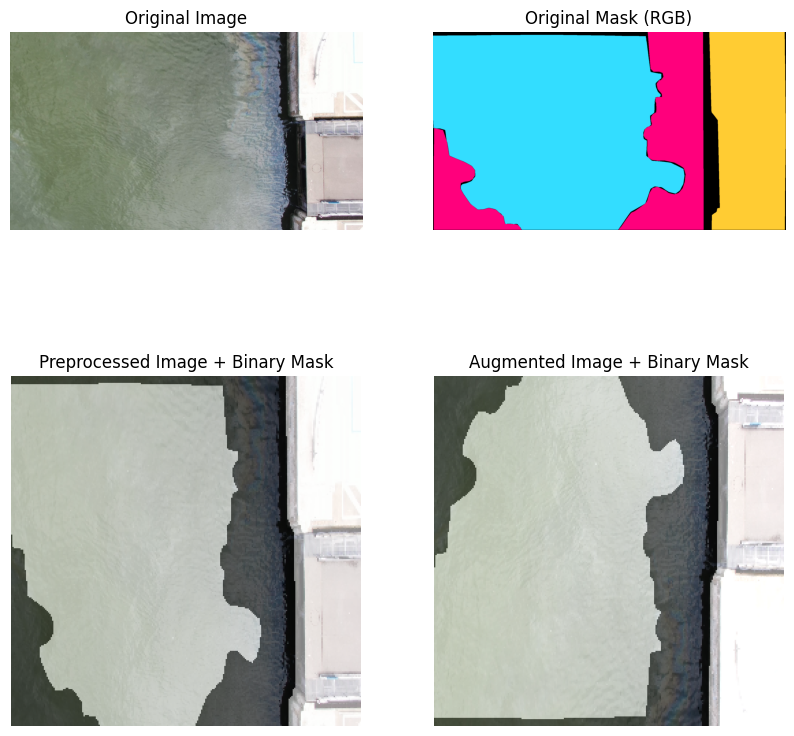

In [ ]:
def visualize_pipeline(img_path, mask_path):
    # Original
    orig_img = load_image(img_path)
    orig_mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)

    # binary preprocessed (basic_transform, no aug)
    preproc = basic_transform(image=orig_img, mask=load_mask(mask_path))
    pre_img, pre_mask = preproc['image'], preproc['mask']
    pre_img = pre_img.permute(1,2,0).numpy()
    pre_img = (pre_img * 0.5) + 0.5  # denormalize for display
    pre_mask = pre_mask.numpy()

    # augmented
    aug = augment_transform(image=orig_img, mask=load_mask(mask_path))
    aug_img, aug_mask = aug['image'], aug['mask']
    aug_img = aug_img.permute(1,2,0).numpy()
    aug_img = (aug_img * 0.5) + 0.5  # denormalize
    aug_mask = aug_mask.numpy()

    # plot
    fig, ax = plt.subplots(2, 2, figsize=(10,10))

    ax[0,0].imshow(orig_img)
    ax[0,0].set_title("Original Image"); ax[0,0].axis("off")

    ax[0,1].imshow(orig_mask)
    ax[0,1].set_title("Original Mask (RGB)"); ax[0,1].axis("off")

    ax[1,0].imshow(pre_img)
    ax[1,0].imshow(pre_mask, cmap='gray', alpha=0.5)  # overlay mask
    ax[1,0].set_title("Preprocessed Image + Binary Mask"); ax[1,0].axis("off")

    ax[1,1].imshow(aug_img)
    ax[1,1].imshow(aug_mask, cmap='gray', alpha=0.5)
    ax[1,1].set_title("Augmented Image + Binary Mask"); ax[1,1].axis("off")

    plt.show()

visualize_pipeline(train_images[5], train_masks[5])


Visualization Pipeline for Preprocessing & Augmentation:

  - Compared Original image & mask with their preprocessed and augmented versions.

  - Preprocessing: Resized and normalized the image, converted mask into binary form, and overlaid mask on the image.

  - Augmentation: Applied random flips, rotations, and brightness/contrast changes to generate diverse training examples.

  - Displayed results in a 2x2 grid → Original vs Preprocessed vs Augmented, making it easy to visually verify correctness.
  - This confirms that input images and masks are properly aligned, and augmentations maintain semantic correctness.

MILESTONE 1 COMPLETED!

Using device: cuda

 Epoch 1/20


 Train Loss: 0.8758 | Val Loss: 0.5495 | Val Acc: 0.9281
   -> Checkpoint saved to: /content/drive/MyDrive/model_checkpoint.pth

 Epoch 2/20


 Train Loss: 0.5573 | Val Loss: 0.4043 | Val Acc: 0.9383
   -> Checkpoint saved to: /content/drive/MyDrive/model_checkpoint.pth

 Epoch 3/20


 Train Loss: 0.4447 | Val Loss: 0.4550 | Val Acc: 0.9098

 Epoch 4/20


 Train Loss: 0.3714 | Val Loss: 0.3254 | Val Acc: 0.9306
   -> Checkpoint saved to: /content/drive/MyDrive/model_checkpoint.pth

 Epoch 5/20


 Train Loss: 0.3303 | Val Loss: 0.3484 | Val Acc: 0.9319

 Epoch 6/20


 Train Loss: 0.3007 | Val Loss: 0.2498 | Val Acc: 0.9496
   -> Checkpoint saved to: /content/drive/MyDrive/model_checkpoint.pth

 Epoch 7/20


 Train Loss: 0.2785 | Val Loss: 0.1977 | Val Acc: 0.9619
   -> Checkpoint saved to: /content/drive/MyDrive/model_checkpoint.pth

 Epoch 8/20


 Train Loss: 0.2688 | Val Loss: 0.2007 | Val Acc: 0.9598

 Epoch 9/20


 Train Loss: 0.2345 | Val Loss: 0.2502 | Val Acc: 0.9444

 Epoch 10/20


 Train Loss: 0.2454 | Val Loss: 0.1649 | Val Acc: 0.9676
   -> Checkpoint saved to: /content/drive/MyDrive/model_checkpoint.pth

 Epoch 11/20


 Train Loss: 0.2382 | Val Loss: 0.1657 | Val Acc: 0.9670

 Epoch 12/20


 Train Loss: 0.1948 | Val Loss: 0.1463 | Val Acc: 0.9706
   -> Checkpoint saved to: /content/drive/MyDrive/model_checkpoint.pth

 Epoch 13/20


 Train Loss: 0.1969 | Val Loss: 0.1421 | Val Acc: 0.9703
   -> Checkpoint saved to: /content/drive/MyDrive/model_checkpoint.pth

 Epoch 14/20


 Train Loss: 0.1996 | Val Loss: 0.1546 | Val Acc: 0.9674

 Epoch 15/20


 Train Loss: 0.1836 | Val Loss: 0.1445 | Val Acc: 0.9698

 Epoch 16/20


 Train Loss: 0.1832 | Val Loss: 0.1344 | Val Acc: 0.9707
   -> Checkpoint saved to: /content/drive/MyDrive/model_checkpoint.pth

 Epoch 17/20


 Train Loss: 0.1981 | Val Loss: 0.1470 | Val Acc: 0.9695

 Epoch 18/20


 Train Loss: 0.1758 | Val Loss: 0.1337 | Val Acc: 0.9702
   -> Checkpoint saved to: /content/drive/MyDrive/model_checkpoint.pth

 Epoch 19/20


 Train Loss: 0.1715 | Val Loss: 0.1277 | Val Acc: 0.9713
   -> Checkpoint saved to: /content/drive/MyDrive/model_checkpoint.pth

 Epoch 20/20


 Train Loss: 0.1633 | Val Loss: 0.1398 | Val Acc: 0.9686

 Training finished! Checkpoint is permanently saved.


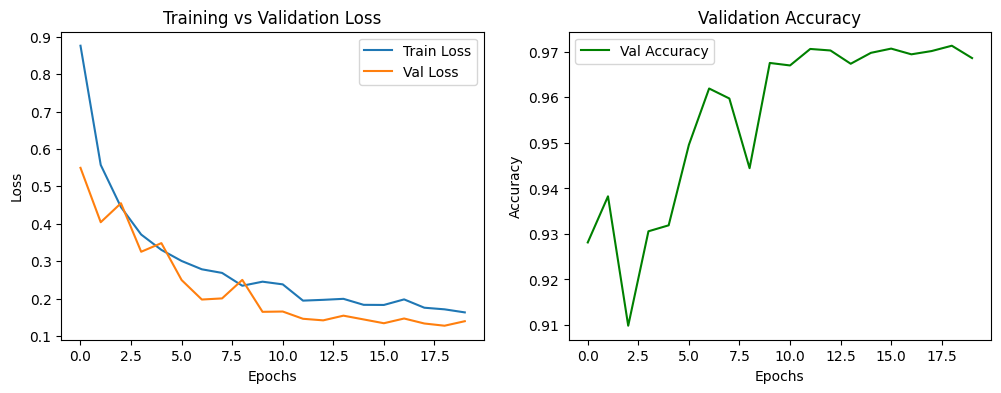

In [ ]:
# model training
!pip install segmentation-models-pytorch --quiet

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt

MODEL_CHECKPOINT_PATH = "/content/drive/MyDrive/model_checkpoint.pth"

# --- THE SMART CHECK ---
if os.path.exists(MODEL_CHECKPOINT_PATH):
    # --- SCENARIO 1: CHECKPOINT EXISTS ---
    print("✅ Checkpoint found! Loading training results...")

    # Load the entire checkpoint
    checkpoint = torch.load(MODEL_CHECKPOINT_PATH)

    # Load the training history from the checkpoint
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    val_accuracies = checkpoint['val_accuracies']

    print("-" * 30)
    print("Displaying saved training history:")
    for epoch in range(len(train_losses)):
        print(f"Epoch {epoch+1}/{len(train_losses)} | Train Loss: {train_losses[epoch]:.4f} | Val Loss: {val_losses[epoch]:.4f} | Val Acc: {val_accuracies[epoch]:.4f}")

    print("-" * 30)
    print("Best Model Validation Loss from this run:", checkpoint.get('best_val_loss', 'N/A'))
    print("Model is ready for deployment.")

    # Re-create the plots from the saved history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.title("Saved Training vs Validation Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(val_accuracies, label="Val Accuracy", color="green")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy")
    plt.title("Saved Validation Accuracy")
    plt.legend()
    plt.show()

else:
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Using device:", device)


  # model (U-Net with ResNet34 encoder)
  model = smp.Unet(
      encoder_name="resnet34",      # backbone
      encoder_weights="imagenet",   # pretrained weights
      in_channels=3,                # RGB images
      classes=1                     # binary segmentation
  ).to(device)


  # loss and optimizer
  dice_loss = smp.losses.DiceLoss(mode="binary")
  bce_loss  = nn.BCEWithLogitsLoss()

  def combined_loss(y_pred, y_true):
      return dice_loss(y_pred, y_true) + bce_loss(y_pred, y_true)

  optimizer = optim.Adam(model.parameters(), lr=1e-4)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(
      optimizer, mode="min", factor=0.5, patience=3
  )

  # data loaders
  train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
  val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

  # metrics
  def pixel_accuracy(outputs, masks):
      preds = (torch.sigmoid(outputs) > 0.5).float()
      correct = (preds == masks).float().sum()
      total = torch.numel(masks)
      return correct / total


  # training and validation loops
  def train_one_epoch(model, loader, optimizer):
      model.train()
      epoch_loss = 0
      for imgs, masks in tqdm(loader, desc="Training", leave=False):
          imgs, masks = imgs.to(device), masks.to(device).unsqueeze(1).float()

          optimizer.zero_grad()
          outputs = model(imgs)
          loss = combined_loss(outputs, masks)
          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()
      return epoch_loss / len(loader)


  def validate_one_epoch(model, loader):
      model.eval()
      epoch_loss = 0
      epoch_acc = 0
      with torch.no_grad():
          for imgs, masks in tqdm(loader, desc="Validation", leave=False):
              imgs, masks = imgs.to(device), masks.to(device).unsqueeze(1).float()
              outputs = model(imgs)

              loss = combined_loss(outputs, masks)
              acc  = pixel_accuracy(outputs, masks)

              epoch_loss += loss.item()
              epoch_acc  += acc.item()

      return epoch_loss / len(loader), epoch_acc / len(loader)


  # training loop
  num_epochs = 20
  train_losses, val_losses, val_accuracies = [], [], []
  best_val_loss = float("inf")

  for epoch in range(num_epochs):
      print(f"\n Epoch {epoch+1}/{num_epochs}")

      train_loss = train_one_epoch(model, train_loader, optimizer)
      val_loss, val_acc = validate_one_epoch(model, val_loader)

      train_losses.append(train_loss)
      val_losses.append(val_loss)
      val_accuracies.append(val_acc)

      scheduler.step(val_loss)

      print(f" Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

      # Save best model
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          checkpoint = {
                  'model_state_dict': model.state_dict(),
                  'train_losses': train_losses,
                  'val_losses': val_losses,
                  'val_accuracies': val_accuracies,
                  'best_val_loss': best_val_loss,
              }
          torch.save(checkpoint, MODEL_CHECKPOINT_PATH)
          print(f"   -> Checkpoint saved to: {MODEL_CHECKPOINT_PATH}")

  print("\n Training finished! Checkpoint is permanently saved.")



  # plots
  plt.figure(figsize=(12,4))

  plt.subplot(1,2,1)
  plt.plot(train_losses, label="Train Loss")
  plt.plot(val_losses, label="Val Loss")
  plt.xlabel("Epochs"); plt.ylabel("Loss")
  plt.title("Training vs Validation Loss")
  plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy", color="green")
plt.xlabel("Epochs"); plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.show()



In [ ]:
!pip install segmentation-models-pytorch --quiet

import torch
import segmentation_models_pytorch as smp
from google.colab import drive
import os

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Mount Drive
drive.mount('/content/drive', force_remount=True)

MODEL_CHECKPOINT_PATH = "/content/drive/MyDrive/model_checkpoint.pth"

if not os.path.exists(MODEL_CHECKPOINT_PATH):
    print("❌ ERROR: Checkpoint file not found!")
    print(f"Please run the training cell first to create the file at: {MODEL_CHECKPOINT_PATH}")
else:
  # Define model architecture
  model = smp.Unet(
      encoder_name="resnet34",
      encoder_weights=None,  # set None, since you will load trained weights
      in_channels=3,
      classes=1
  ).to(device)

  checkpoint = torch.load(MODEL_CHECKPOINT_PATH, map_location=device)

  model.load_state_dict(checkpoint['model_state_dict'])

  model.eval()
  print("✅ Trained model loaded successfully from checkpoint and is ready.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 12.7 MB/s eta 0:00:00
Using device: cuda
Mounted at /content/drive
✅ Trained model loaded successfully from checkpoint and is ready.


1. Pretrained Encoder (ResNet34 on ImageNet)  
   - The U-Net uses ResNet34 pretrained on ImageNet as the encoder.  
   - This gives the model strong feature extraction ability from the start, instead of learning from scratch.

2. Binary Segmentation Task  
   - Since the problem is object vs. background (2 classes), it is easier to achieve high pixel-level accuracy.  

3. Pixel Accuracy Metric  
   - Pixel accuracy counts all pixels.  
   - If the dataset has more background pixels than object pixels, the model can appear very accurate even with partial learning.  

4. Combined Loss Function (BCE + Dice)  
   - BCE ensures stable optimization.  
   - Dice focuses directly on overlap between predictions and ground truth.  
   - This combination accelerates convergence.

5. Clean Dataset  
   - Well-prepared masks with clear object boundaries reduce noise and help the model perform better quickly.

That's why the model shows high accuracy from the very first epoch.

Using the model loaded from the previous cell.


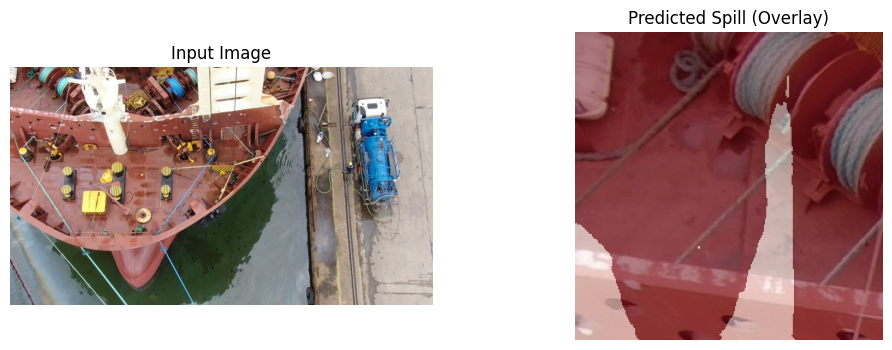

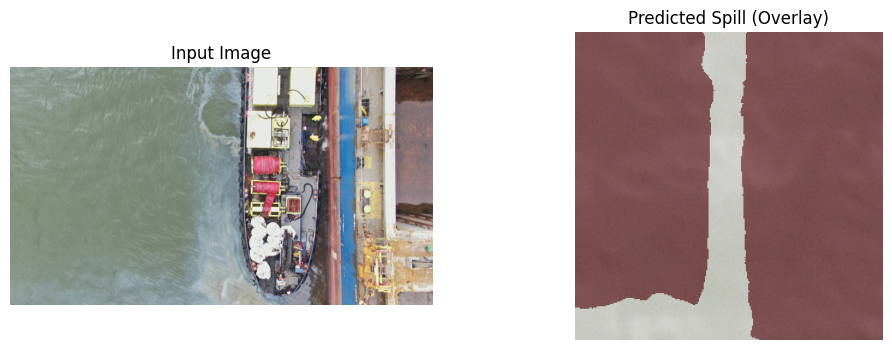

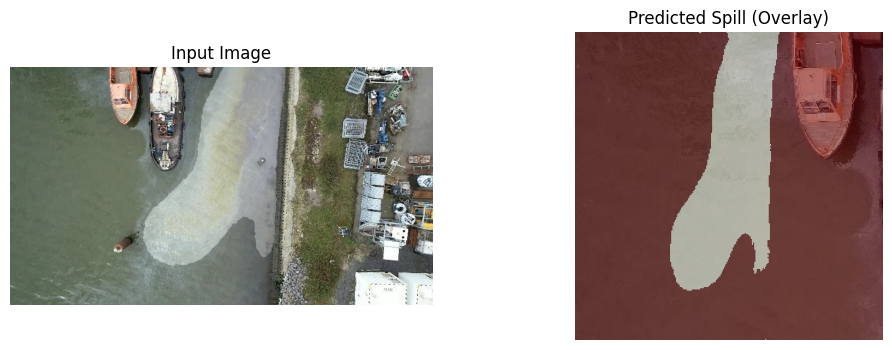

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

# load model
# model.load_state_dict(torch.load("best_model.pth", map_location=device))
print("Using the model loaded from the previous cell.")
model.eval()

# preprocessing (same as training)
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),   # resize to training size
#     transforms.ToTensor()
# ])

# def predict_image(img_path):
#     # Load image
#     img = Image.open(img_path).convert("RGB")
#     inp = transform(img).unsqueeze(0).to(device)  # [1, 3, H, W]

#     # Predict
#     with torch.no_grad():
#         out = model(inp)
#         pred_mask = torch.sigmoid(out).squeeze().cpu().numpy()

#     # Threshold at 0.5
#     binary_mask = (pred_mask > 0.5).astype("float32")

#     # plot
#     plt.figure(figsize=(10,4))
#     plt.subplot(1,3,1); plt.imshow(img); plt.title("Input Image"); plt.axis("off")
#     plt.subplot(1,3,2); plt.imshow(pred_mask, cmap="gray"); plt.title("Predicted Mask"); plt.axis("off")
#     plt.subplot(1,3,3); plt.imshow(binary_mask, cmap="gray"); plt.title("Binary Mask"); plt.axis("off")
#     plt.show()

transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

# --- 3. Define the prediction and visualization function ---
def predict_image(img_path):
    # Load image using OpenCV (as done in our dataset) and convert to RGB
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Preprocess the image
    transformed = transform(image=image)
    input_tensor = transformed['image'].unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        # Apply sigmoid and threshold to get the binary mask
        pred_mask = (torch.sigmoid(output).squeeze().cpu().numpy() > 0.5).astype(float)

    # Plot the results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(pred_mask, cmap='Reds', alpha=0.5) # Show mask as a red overlay
    plt.title("Predicted Spill (Overlay)")
    plt.axis("off")
    plt.show()

# test on dataset images
predict_image("/content/drive/MyDrive/infosys/oil_spill_dataset/train/images/Oil (1135).jpg")
predict_image("/content/drive/MyDrive/infosys/oil_spill_dataset/train/images/Oil (1170).jpg")
predict_image("/content/drive/MyDrive/infosys/oil_spill_dataset/train/images/Oil (1193).jpg")


Testing the Model on Sample Images

  - Mounted Google Drive to access dataset.

  - Selected spill images for prediction.

  - Verified predictions by visualizing the segmentation outputs.

In [ ]:
# Improved Training Setup
from torchvision import transforms
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMPROVED_MODEL_CHECKPOINT_PATH = "/content/drive/MyDrive/improved_model_checkpoint.pth"

if os.path.exists(IMPROVED_MODEL_CHECKPOINT_PATH):
    print("✅ IMPROVED model checkpoint found! Loading previous training results...")
    checkpoint = torch.load(IMPROVED_MODEL_CHECKPOINT_PATH)
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    val_accuracies = checkpoint['val_accuracies']

    print("-" * 30)
    print("Displaying saved training history for the IMPROVED model:")
    for epoch in range(len(train_losses)):
        print(f"Epoch {epoch+1}/{len(train_losses)} | Train Loss: {train_losses[epoch]:.4f} | Val Loss: {val_losses[epoch]:.4f} | Val Acc: {val_accuracies[epoch]:.4f}")

    print("-" * 30)
    print("Best Model Validation Loss from this run:", checkpoint.get('best_val_loss', 'N/A'))

    # Re-create the plots
    plt.figure(figsize=(12,4)); plt.subplot(1,2,1); plt.plot(train_losses, label="Train Loss"); plt.plot(val_losses, label="Val Loss"); plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("Saved Training vs Validation Loss"); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_accuracies, label="Val Accuracy", color="green"); plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.title("Saved Validation Accuracy"); plt.legend(); plt.show()

else:
    print("🚀 No improved checkpoint found. Starting a new, improved training session...")

    # Define Improved Augmentations using Albumentations
    improved_train_transform = A.Compose([
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=45, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])
    # Validation transform remains basic
    basic_transform = A.Compose([
        A.Resize(256, 256), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), ToTensorV2(),
    ])

    # Create New Datasets and DataLoaders
    improved_train_dataset = OilSpillDataset(train_images, train_masks, transform=improved_train_transform)
    val_dataset = OilSpillDataset(val_images, val_masks, transform=basic_transform) # Re-use val dataset
    improved_train_loader = DataLoader(improved_train_dataset, batch_size=8, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0) # Re-use val loader

    # Setup Model, Loss, Optimizer, and Early Stopping
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)

    # Your improved loss and optimizer
    dice_loss = smp.losses.DiceLoss(mode="binary")
    bce_loss  = nn.BCEWithLogitsLoss()
    def combined_loss(y_pred, y_true): return 0.7 * dice_loss(y_pred, y_true) + 0.3 * bce_loss(y_pred, y_true)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    # Your Early Stopping class
    class EarlyStopping:
        def __init__(self, patience=5): self.patience, self.counter, self.best_loss, self.early_stop = patience, 0, float("inf"), False
        def __call__(self, val_loss):
            if val_loss < self.best_loss: self.best_loss, self.counter = val_loss, 0
            else:
                self.counter += 1
                if self.counter >= self.patience: self.early_stop = True
    early_stopping = EarlyStopping(patience=5)

    # training utility functions
    def pixel_accuracy(outputs, masks): preds=(torch.sigmoid(outputs)>0.5).float(); return (preds==masks).float().sum()/torch.numel(masks)
    def train_one_epoch(model, loader, optimizer):
        model.train(); epoch_loss=0
        for i, m in tqdm(loader, desc="Training", leave=False): i,m=i.to(device),m.to(device).unsqueeze(1).float(); optimizer.zero_grad(); o=model(i); l=combined_loss(o,m); l.backward(); optimizer.step(); epoch_loss+=l.item()
        return epoch_loss/len(loader)
    def validate_one_epoch(model, loader):
        model.eval(); epoch_loss,epoch_acc=0,0
        with torch.no_grad():
            for i,m in tqdm(loader, desc="Validation", leave=False): i,m=i.to(device),m.to(device).unsqueeze(1).float(); o=model(i); l=combined_loss(o,m); a=pixel_accuracy(o,m); epoch_loss+=l.item(); epoch_acc+=a.item()
        return epoch_loss/len(loader), epoch_acc/len(loader)

    num_epochs = 20
    train_losses, val_losses, val_accuracies = [], [], []
    for epoch in range(num_epochs):
        print(f"\nImproved Epoch {epoch+1}/{num_epochs}")
        train_loss = train_one_epoch(model, improved_train_loader, optimizer)
        val_loss, val_acc = validate_one_epoch(model, val_loader)
        train_losses.append(train_loss); val_losses.append(val_loss); val_accuracies.append(val_acc)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Save checkpoint ONLY when validation loss improves
        if val_loss < early_stopping.best_loss:
            checkpoint = {'model_state_dict': model.state_dict(), 'train_losses': train_losses, 'val_losses': val_losses, 'val_accuracies': val_accuracies, 'best_val_loss': val_loss}
            torch.save(checkpoint, IMPROVED_MODEL_CHECKPOINT_PATH)
            print(f"   -> Checkpoint saved to: {IMPROVED_MODEL_CHECKPOINT_PATH}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    print("\n✅ Improved training finished! Checkpoint is permanently saved.")


🚀 No improved checkpoint found. Starting a new, improved training session...
Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]


Improved Epoch 1/20


Train Loss: 0.2791 | Val Loss: 0.1399 | Val Acc: 0.9314
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

Improved Epoch 2/20


Train Loss: 0.1725 | Val Loss: 0.1217 | Val Acc: 0.9369
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

Improved Epoch 3/20


Train Loss: 0.1620 | Val Loss: 0.1259 | Val Acc: 0.9283

Improved Epoch 4/20


Train Loss: 0.1329 | Val Loss: 0.1272 | Val Acc: 0.9340

Improved Epoch 5/20


Train Loss: 0.1243 | Val Loss: 0.1091 | Val Acc: 0.9536
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

Improved Epoch 6/20


Train Loss: 0.1224 | Val Loss: 0.0882 | Val Acc: 0.9589
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

Improved Epoch 7/20


Train Loss: 0.1150 | Val Loss: 0.0780 | Val Acc: 0.9603
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

Improved Epoch 8/20


Train Loss: 0.1052 | Val Loss: 0.1060 | Val Acc: 0.9422

Improved Epoch 9/20


Train Loss: 0.0935 | Val Loss: 0.0685 | Val Acc: 0.9640
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

Improved Epoch 10/20


Train Loss: 0.0928 | Val Loss: 0.0728 | Val Acc: 0.9611

Improved Epoch 11/20


Train Loss: 0.0965 | Val Loss: 0.0675 | Val Acc: 0.9652
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

Improved Epoch 12/20


Train Loss: 0.0831 | Val Loss: 0.0658 | Val Acc: 0.9651
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

Improved Epoch 13/20


Train Loss: 0.1009 | Val Loss: 0.0635 | Val Acc: 0.9661
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

Improved Epoch 14/20


Train Loss: 0.0762 | Val Loss: 0.0634 | Val Acc: 0.9665
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

Improved Epoch 15/20


Train Loss: 0.0824 | Val Loss: 0.0583 | Val Acc: 0.9701
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

Improved Epoch 16/20


Train Loss: 0.0832 | Val Loss: 0.0669 | Val Acc: 0.9653

Improved Epoch 17/20


Train Loss: 0.0719 | Val Loss: 0.0592 | Val Acc: 0.9709

Improved Epoch 18/20


Train Loss: 0.0831 | Val Loss: 0.0641 | Val Acc: 0.9652

Improved Epoch 19/20


Train Loss: 0.0796 | Val Loss: 0.0562 | Val Acc: 0.9689
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

Improved Epoch 20/20


Train Loss: 0.0716 | Val Loss: 0.0512 | Val Acc: 0.9720
   -> Checkpoint saved to: /content/drive/MyDrive/improved_model_checkpoint.pth

✅ Improved training finished! Checkpoint is permanently saved.


In [ ]:
import torch
import segmentation_models_pytorch as smp
from google.colab import drive
import os

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Mount Drive
drive.mount('/content/drive', force_remount=True)

IMPROVED_MODEL_CHECKPOINT_PATH = "/content/drive/MyDrive/improved_model_checkpoint.pth"

if not os.path.exists(IMPROVED_MODEL_CHECKPOINT_PATH):
    print(f"❌ ERROR: Improved model checkpoint not found at {IMPROVED_MODEL_CHECKPOINT_PATH}")
    print("Please run the 'Improved Model Training' cell (Cell 6) first.")
else:
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights=None, # Always None when loading custom weights
        in_channels=3,
        classes=1
    ).to(device)

    checkpoint = torch.load(IMPROVED_MODEL_CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict']) # <-- This is the key correction

    model.eval()
    print("✅ IMPROVED trained model loaded successfully from checkpoint and is ready for use.")

Using device: cuda
Mounted at /content/drive
✅ IMPROVED trained model loaded successfully from checkpoint and is ready for use.


Improved Training Setup

1. Data Augmentation

Training images are randomly flipped, rotated, and color-jittered.

This prevents overfitting by making the model robust to variations in orientation, brightness, and contrast.

Validation images are kept clean (only converted to tensors) to ensure fair evaluation.


2. Optimizer with Weight Decay

Adam optimizer is used with a small weight decay (L2 regularization).

This penalizes overly large weights and helps reduce overfitting.

3. Combined Loss Function (Dice + BCE, weighted)

The loss combines 70% Dice Loss and 30% Binary Cross-Entropy Loss.

Dice focuses on segmentation overlap (region similarity).

BCE provides stable pixel-wise classification.

The weighting ensures overlap accuracy is prioritized while keeping optimization stable.

4. Early Stopping

Training automatically stops if validation loss doesn’t improve for 5 epochs.

Prevents unnecessary training and avoids overfitting.

5. Validation Function

For each validation step, it calculates both average loss and pixel-level accuracy.

This helps track not just how well the model minimizes loss but also how precise the segmentation is at pixel level.

6. Learning Rate Scheduler

ReduceLROnPlateau lowers the learning rate when validation loss plateaus.

This fine-tunes learning in later epochs for better convergence.

7. Model Checkpointing

The best model (highest validation accuracy) is saved as best_model_improved.pth.

Ensures you always keep the strongest model, even if later epochs degrade.

8. Overall Benefit

With augmentation, combined loss, early stopping, LR scheduling, and checkpointing, this setup builds a robust end-to-end training pipeline that reduces overfitting, improves generalization, and ensures reliable segmentation performance.

✅ Checkpoint found. Loading and plotting the saved training history...


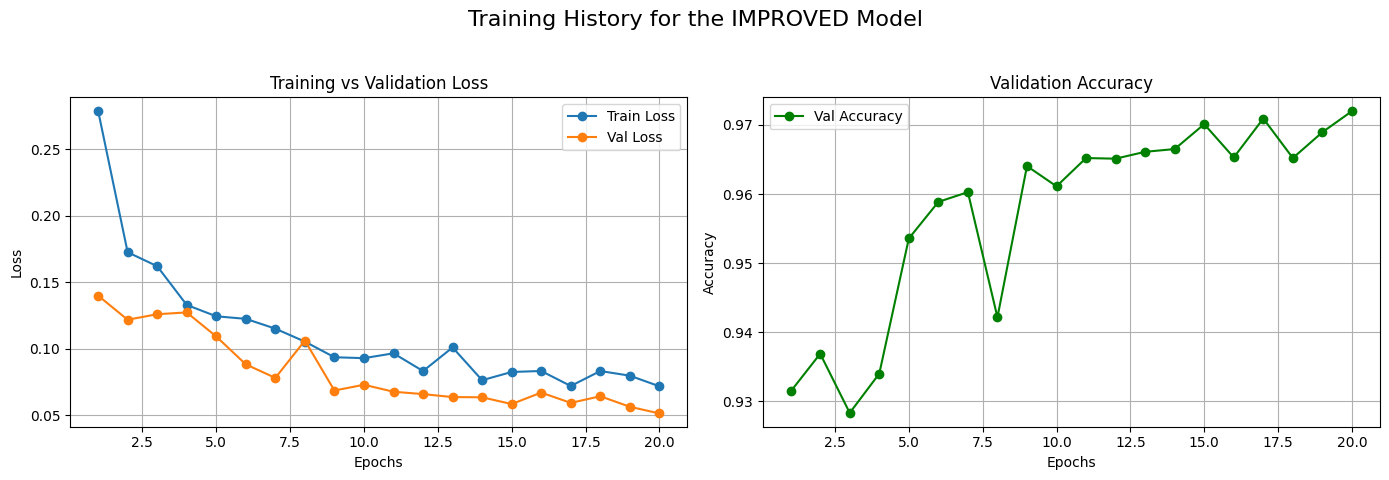

In [ ]:
import matplotlib.pyplot as plt
import torch
import os

IMPROVED_MODEL_CHECKPOINT_PATH = "/content/drive/MyDrive/improved_model_checkpoint.pth"

if not os.path.exists(IMPROVED_MODEL_CHECKPOINT_PATH):
    print(f"❌ ERROR: Checkpoint file not found at {IMPROVED_MODEL_CHECKPOINT_PATH}")
    print("Please run the 'Improved Model Training' cell first to generate the history.")
else:
    print("✅ Checkpoint found. Loading and plotting the saved training history...")
    checkpoint = torch.load(IMPROVED_MODEL_CHECKPOINT_PATH)

    train_losses = checkpoint.get('train_losses')
    val_losses = checkpoint.get('val_losses')
    val_accuracies = checkpoint.get('val_accuracies')

    if train_losses and val_losses and val_accuracies:
        epochs = range(1, len(train_losses) + 1)
        plt.figure(figsize=(14, 5))
        plt.suptitle("Training History for the IMPROVED Model", fontsize=16)

        # Loss curve
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, label="Train Loss", marker="o")
        plt.plot(epochs, val_losses, label="Val Loss", marker="o")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.grid(True)
        # Zoom in on the y-axis
        plt.ylim(min(min(train_losses), min(val_losses)) - 0.01, max(max(train_losses), max(val_losses)) + 0.01)

        # Accuracy curve
        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_accuracies, label="Val Accuracy", color="green", marker="o")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Validation Accuracy")
        plt.legend()
        plt.grid(True)
        # Zoom in on the y-axis
        plt.ylim(min(val_accuracies) - 0.002, max(val_accuracies) + 0.002)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
        plt.show()
    else:
        print("❌ ERROR: Could not find training history lists inside the checkpoint file.")


Training & Validation Curves

Loss Curve: Shows how training and validation loss change over epochs. A decreasing loss with small gap indicates good learning and low overfitting.

Accuracy Curve: Tracks validation accuracy across epochs. A steady upward trend reflects improved segmentation quality.

Zoomed Y-axis: Tight limits highlight small improvements, making convergence patterns clearer.

👉 These plots help diagnose underfitting, overfitting, and model stability at a glance.

In [30]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from tqdm import tqdm # Import tqdm for the progress bar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMPROVED_MODEL_CHECKPOINT_PATH = "/content/drive/MyDrive/improved_model_checkpoint.pth"

if not os.path.exists(IMPROVED_MODEL_CHECKPOINT_PATH):
    print(f"❌ ERROR: Checkpoint file not found at {IMPROVED_MODEL_CHECKPOINT_PATH}")
else:
    print("✅ Checkpoint found. Loading the IMPROVED model for final evaluation.")
    model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=1).to(device)
    checkpoint = torch.load(IMPROVED_MODEL_CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # We must use the exact same basic preprocessing as the validation set.
    basic_transform = A.Compose([
        A.Resize(256, 256), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), ToTensorV2(),
    ])
    test_images = sorted(glob.glob(os.path.join(DATASET_PATH, "test/images/*")))
    test_masks = sorted(glob.glob(os.path.join(DATASET_PATH, "test/masks/*")))
    test_dataset = OilSpillDataset(test_images, test_masks, transform=basic_transform)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)
    print(f"Loaded {len(test_dataset)} images for final testing.")

    # ---- Metric Functions ----
    def dice_coef(y_true, y_pred, smooth=1e-7):
        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        intersection = np.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

    def iou_score(y_true, y_pred, smooth=1e-7):
        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        intersection = np.sum(y_true_f * y_pred_f)
        union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
        return (intersection + smooth) / (union + smooth)

    def evaluate_model(model, dataloader, device):
        model.eval()
        dice_scores, iou_scores, precisions, recalls, f1s = [], [], [], [], []

        with torch.no_grad():
            for images, masks in dataloader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
                true = masks.cpu().numpy()

                for t, p in zip(true, preds):
                    t, p = t.flatten(), p.flatten()
                    dice_scores.append(dice_coef(t, p))
                    iou_scores.append(iou_score(t, p))
                    precisions.append(precision_score(t, p, zero_division=0))
                    recalls.append(recall_score(t, p, zero_division=0))
                    f1s.append(f1_score(t, p, zero_division=0))

        return {
            "Dice": np.mean(dice_scores),
            "IoU": np.mean(iou_scores),
            "Precision": np.mean(precisions),
            "Recall": np.mean(recalls),
            "F1-score": np.mean(f1s),
        }

    # Evaluate the model on the TEST loader
    print("\nCalculating final performance metrics on the TEST dataset...")
    final_metrics = evaluate_model(model, test_loader, device)
    print("\n--- Final Test Metrics ---")
    for key, value in final_metrics.items():
      print(f"{key}: {value:.4f}")
    print("--------------------------\n")

    def denormalize_image(image_tensor):
      """
      THIS IS THE KEY CORRECTION.
      It properly reverses the normalization transform for correct color display.
      """
      img_np = image_tensor.numpy().transpose(1, 2, 0) # C,H,W -> H,W,C
      mean = np.array([0.5, 0.5, 0.5])
      std = np.array([0.5, 0.5, 0.5])
      img_np = std * img_np + mean # Reverse the normalization
      return np.clip(img_np, 0, 1) # Clip values to be between 0 and 1



    def visualize_predictions_4_columns(model, dataset, device, num_samples=3):
      model.eval()
      indices = random.sample(range(len(dataset)), num_samples)

      for i, idx in enumerate(indices):
        plt.figure(figsize=(20, 5))
        image_tensor, mask_tensor = dataset[idx]
        with torch.no_grad():
          pred_mask = (torch.sigmoid(model(image_tensor.unsqueeze(0).to(device))).cpu().numpy()[0,0] > 0.5)

        # Use the CORRECT denormalization function
        img_to_display = denormalize_image(image_tensor)
        gt_mask = mask_tensor.squeeze().cpu().numpy()

        # Plot Original Image
        plt.subplot(1, 4, 1); plt.imshow(img_to_display); plt.title("Original Image"); plt.axis('off')
        # Plot Ground Truth Mask
        plt.subplot(1, 4, 2); plt.imshow(gt_mask, cmap='gray'); plt.title("Ground Truth Mask"); plt.axis('off')
        # Plot Predicted Mask
        plt.subplot(1, 4, 3); plt.imshow(pred_mask, cmap='gray'); plt.title("Predicted Mask"); plt.axis('off')
        # Overlay Prediction on Image
        plt.subplot(1, 4, 4); plt.imshow(img_to_display); plt.imshow(pred_mask, alpha=0.5, cmap='Reds'); plt.title("Predicted Overlay"); plt.axis('off')

        plt.tight_layout()
        plt.show()

    print("Displaying 4-column visual predictions on random TEST images...")
    # Evaluate on the TEST dataset for the final report
    visualize_predictions_4_columns(model, test_dataset, device, num_samples=3)


Output hidden; open in https://colab.research.google.com to view.

Extended Evaluation & Visualization

1. Multiple Evaluation Metrics

Dice Coefficient: Measures overlap between predicted and ground-truth masks; very sensitive to segmentation quality.

IoU (Jaccard Index): Ratio of intersection to union between masks, a stricter version of overlap.

Precision: How many predicted pixels are actually correct (low false positives).

Recall: How many true pixels the model captures (low false negatives).

F1-score: Harmonic mean of Precision and Recall, balances both aspects.

Using multiple metrics ensures a complete picture of model performance beyond just accuracy.

2. Evaluation Function

Loops over the validation set.

Applies the trained model and thresholds predictions at 0.5.

Computes metrics per sample, averages results across dataset.

Provides a dictionary of scores (Dice, IoU, Precision, Recall, F1).

This gives a quantitative snapshot of segmentation quality.

3. Visualization Function
For qualitative analysis, each sample is displayed with 4 views side by side:

Original Image (input to the model).

Ground Truth Mask (the annotated oil spill region).

Predicted Mask (binary output of the model).

Overlay View (prediction layered on the original image in red).

Images are normalized for proper display.

Random samples are chosen for variety.

Overlays make it easy to see where the model matches or misses the spill boundaries.

4. Why This Matters

Metrics tell how well the model performs numerically.

Visualizations show where the model succeeds or fails in real examples.

Together, they provide both quantitative and qualitative validation of the segmentation pipeline.

In [ ]:
# The Final, Polished Deployment Cell (with Better UI and Visualization)

# --- 1. Install all necessary libraries ---
# This prevents any "ModuleNotFoundError" issues.
!pip install streamlit pyngrok segmentation-models-pytorch --quiet

import os
import shutil
from pyngrok import ngrok

# mount google drive (only once for dataset loading)
from google.colab import drive
drive.mount('/content/drive')

# --- 2. Make the model file local for the Streamlit app ---
print("Copying model from Google Drive to local environment for the app...")
source_path = "/content/drive/MyDrive/improved_model_checkpoint.pth"
destination_path = "/content/improved_model_checkpoint.pth"

if os.path.exists(source_path):
    shutil.copy(source_path, destination_path)
    print("Model copied successfully.")
else:
    print("❌ ERROR: Model checkpoint not found in Google Drive. Please run the training cell first.")
    raise FileNotFoundError(f"Required model file not found at {source_path}")


# --- 3. Define the entire POLISHED Streamlit app as a Python string ---
APP_CODE = """
import streamlit as st
import torch
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import os

# App Configuration
st.set_page_config(layout="wide", page_title="AI SpillGuard")

# Model Loading
@st.cache_resource
def load_model():
    '''Load the model from the LOCAL checkpoint file.'''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=1)
    checkpoint_path = "/content/improved_model_checkpoint.pth"
    if not os.path.exists(checkpoint_path):
        st.error("Model checkpoint file not found!")
        return None, None
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model, device

model, device = load_model()

# --- UI Sidebar ---
st.sidebar.title("🌊 AI SpillGuard")
st.sidebar.info(
    "This application uses a U-Net deep learning model to detect and segment oil spills "
    "from satellite imagery. Upload an image to begin the analysis."
)

# --- Main App Logic ---
st.title("Real-Time Oil Spill Detection System")
uploaded_file = st.file_uploader("Upload a satellite image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None and model is not None:
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    original_image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    st.header("Analysis Results")
    col1, col2 = st.columns(2)
    # Fix the warning by using use_container_width=True
    col1.image(original_image, caption='Uploaded Image', width='stretch')

    with st.spinner('Analyzing image...'):
        transform = A.Compose([A.Resize(256, 256), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), ToTensorV2()])
        input_tensor = transform(image=original_image)['image'].unsqueeze(0).to(device)
        with torch.no_grad():
            pred_mask = (torch.sigmoid(model(input_tensor)).squeeze().cpu().numpy() > 0.9).astype(np.uint8)

        kernel = np.ones((7, 7), np.uint8)
        pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel)

        # Now, make the final decision based on the CLEANED mask
        is_spill = np.sum(pred_mask) > (pred_mask.size * 0.01)

        with col2:
            # --- BETTER VISUALIZATION: Create a semi-transparent overlay ---
            # Resize mask to match original image size
            pred_mask_resized = cv2.resize(pred_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

            # Create a red color mask
            color_mask = np.zeros_like(original_image)
            color_mask[pred_mask_resized == 1] = [255, 0, 0] # Red color for the spill

            # Blend the color mask with the original image
            # The alpha value (0.4) controls the transparency
            overlay_image = cv2.addWeighted(original_image, 1, color_mask, 0.4, 0)

            st.image(overlay_image, caption='Detection Overlay', width='stretch')
            if is_spill:
                st.error("### Oil Spill Detected!")
            else:
                st.success("### No Spill Detected")

elif model is None:
    st.header("Model Not Loaded")
"""

# --- 4. Write the string to the app.py file ---
with open("app.py", "w") as f:
    f.write(APP_CODE)
print("✅ app.py has been written successfully using standard Python.")

# --- 5. Authenticate ngrok and run the app ---
NGROK_AUTH_TOKEN = "33etIwd9sZngfH44Fve1oJ2zwNg_6kE2uxe2cZ8Q5xDySrp6U"

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok.kill()
public_url = ngrok.connect(8501)
print("🚀 Your app is live! Click this URL to open it:")
print(public_url)
!streamlit run app.py --server.port 8501 --server.headless true --server.fileWatcherType none

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying model from Google Drive to local environment for the app...
Model copied successfully.
✅ app.py has been written successfully using standard Python.
🚀 Your app is live! Click this URL to open it:
NgrokTunnel: "https://ahmad-sallowy-manually.ngrok-free.dev" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.199.56.245:8501

